# 📈 Monte Carlo Stock Return Simulator

Simulating thousands of potential 1-year return paths for the S&P 500 using historical data to assess investment risk and reward. Built using Python and aligned with probabilistic investing concepts.

## 🧠 Objective

- Estimate potential future price paths of the S&P 500 using Monte Carlo simulation
- Visualize the **distribution of outcomes**
- Calculate probabilities of achieving or missing return targets
- Evaluate expected return and downside risk

## 🔧 Import Libraries

In [1]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

## 📥 Download Historical Data
Using Yahoo Finance to fetch adjusted closing prices for the S&P 500 from 2015 to 2024.

In [2]:
# Download S&P 500 data from Yahoo Finance
ticker = "^GSPC"  # S&P 500 index
data = yf.download(ticker, start="2015-01-01", end="2024-12-31", auto_adjust=False)
data = data["Adj Close"]
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


## 📊 Calculate Log Returns, Annualized Mean, and Volatility

In [3]:
# Calculate log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Estimate annualized return and volatility
mu = log_returns.mean() * 252      # Expected return
sigma = log_returns.std() * np.sqrt(252)  # Volatility

## 🎲 Run Monte Carlo Simulations
Simulate 10,000 future price paths for the next 252 trading days (1 year).

In [4]:
# Simulation parameters
np.random.seed(42)
n_simulations = 10000
n_days = 252  # 1 year of trading days
start_price = float(data.iloc[-1])

# Create simulation matrix
simulations = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    daily_returns = np.random.normal(loc=mu/252, scale=sigma/np.sqrt(252), size=n_days)
    price_path = start_price * np.exp(np.cumsum(daily_returns))
    simulations[i] = price_path

## 📈 Analyze Simulation Results
Check probability of exceeding +10%, dropping below –5%, and compute expected return and downside risk.

In [5]:
# Final simulated prices
final_prices = simulations[:, -1]
returns = (final_prices - start_price) / start_price

# Probabilities & Risk
prob_gain_10 = np.mean(returns > 0.10)
prob_loss_5 = np.mean(returns < -0.05)
expected_return = np.mean(returns)
downside_risk = np.std(returns[returns < 0])

## 📊 Visualize Simulated Outcomes

- Left: Histogram of final simulated returns  
- Right: Sample price paths from the simulations

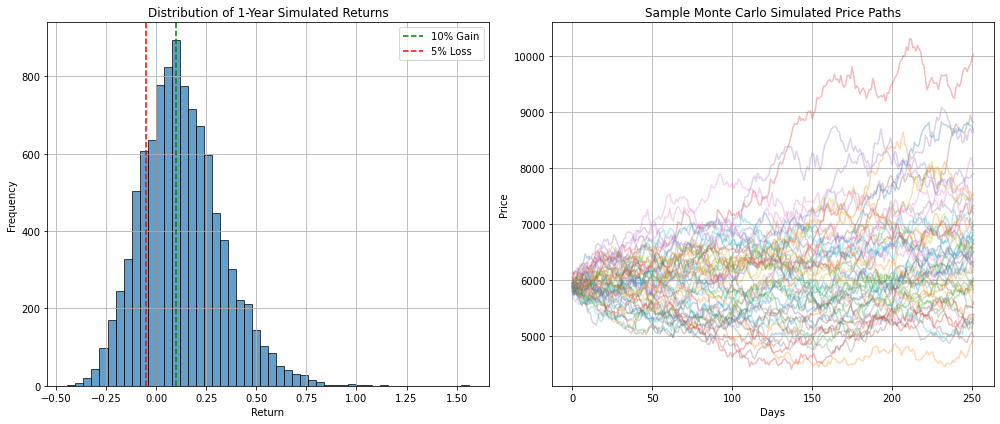

In [6]:
plt.figure(figsize=(14, 6))

# Histogram of return distribution
plt.subplot(1, 2, 1)
plt.hist(returns, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0.10, color='g', linestyle='--', label='10% Gain')
plt.axvline(-0.05, color='r', linestyle='--', label='5% Loss')
plt.title("Distribution of 1-Year Simulated Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.savefig("outputs/return_distribution.png")

# Sample price paths
plt.subplot(1, 2, 2)
for i in range(50):
    plt.plot(simulations[i], alpha=0.3)
plt.title("Sample Monte Carlo Simulated Price Paths")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.savefig("outputs/simulation_paths.png")

plt.tight_layout()
plt.show()

## 📉 Visualizing Downside Risk

This chart highlights the returns that fall below 0% (in red), which are used to calculate **downside risk** — the volatility of negative outcomes only.

Unlike standard deviation, which treats all variation equally, this focuses on **what actually hurts the portfolio**.

/Users/ishitakapoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  app.launch_new_instance()
/Users/ishitakapoor/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
/Users/ishitakapoor/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


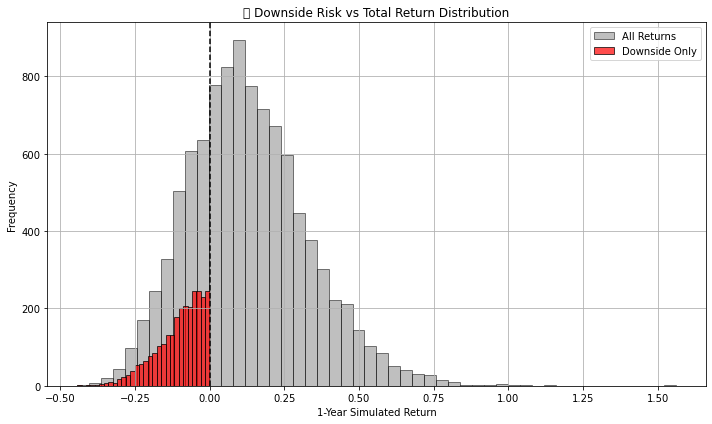

In [7]:
# Visualize downside vs upside returns
plt.figure(figsize=(10, 6))

# Histogram of all returns
plt.hist(returns, bins=50, alpha=0.5, label='All Returns', color='gray', edgecolor='black')

# Highlight downside returns in red
plt.hist(returns[returns < 0], bins=30, alpha=0.7, label='Downside Only', color='red', edgecolor='black')

plt.axvline(0, color='black', linestyle='--')
plt.title("📉 Downside Risk vs Total Return Distribution")
plt.xlabel("1-Year Simulated Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("outputs/downside_risk_highlighted.png")
plt.show()

## 🧾 Summary Table

Key statistics from the simulation:

In [8]:
summary = pd.DataFrame({
    "Expected 1-Year Return": [f"{expected_return*100:.2f}%"],
    "Downside Risk (std of negative returns)": [f"{downside_risk*100:.2f}%"],
    "P(Return > 10%)": [f"{prob_gain_10*100:.2f}%"],
    "P(Return < -5%)": [f"{prob_loss_5*100:.2f}%"]
})

summary

,Expected 1-Year Return,Downside Risk (std of negative returns),P(Return > 10%),P(Return < -5%)
0,12.76%,7.77%,52.24%,19.01%
